In [65]:
import numpy as np
from PIL import Image
import os
import pandas as pd
import umap
import matplotlib.pyplot as plt
import shutil

In [37]:

# Wczytywanie zdjec
root_dir = '../all_preprocessed_filtered'

image_data = []
folders = []
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.png'):
                file_path = os.path.join(folder_path, file)

                img = Image.open(file_path).convert('L')
                img_array = np.array(img)

                flattened_img_array = img_array.flatten()

                image_data.append(flattened_img_array)
                folders.append(folder)

In [38]:
# Create dataframe and save to file (takes a long time)
df = pd.DataFrame(image_data)
df.to_csv("image_df.csv")

In [39]:
# Read dataframe from file
df = pd.read_csv("image_df.csv")
df.drop("Unnamed: 0", axis='columns', inplace=True)

In [40]:
df['Class'] = folders
df['Class'] = df["Class"].astype('int32')
df.dropna(inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4899 entries, 0 to 5123
Columns: 6273 entries, 0 to Class
dtypes: float64(1272), int32(1), int64(5000)
memory usage: 234.5 MB


In [42]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,6263,6264,6265,6266,6267,6268,6269,6270,6271,Class
0,25,26,27,27,25,29,27,26,26,26,...,47.0,51.0,53.0,52.0,51.0,52.0,51.0,53.0,55.0,1
1,27,31,31,28,29,30,31,32,29,31,...,54.0,57.0,55.0,55.0,58.0,57.0,58.0,60.0,63.0,1
2,25,26,26,30,28,27,29,28,28,29,...,41.0,46.0,46.0,46.0,46.0,44.0,50.0,51.0,53.0,1
3,34,35,36,38,38,38,37,36,37,36,...,57.0,59.0,60.0,62.0,61.0,63.0,62.0,59.0,63.0,1
4,30,27,29,33,31,31,33,31,24,26,...,35.0,44.0,48.0,46.0,51.0,43.0,46.0,49.0,49.0,1


In [43]:
# UMAP
reducer = umap.UMAP()
reducer.fit(df.iloc[:, :-1])

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [9]:
# Create embedding for specific classes
mask = df[(df['Class'] > 11) & (df['Class'] < 21)].index
embedding = reducer.transform(df.iloc[:, :-1].loc[mask, :])

In [44]:
# Create all embeddings and save to file
embedding_all = reducer.transform(df.iloc[:, :-1])
emb_df_all = pd.DataFrame(embedding_all)
emb_df_all["Class"] = df['Class'].tolist()
emb_df_all.to_csv("embedding_df_all.csv")

In [45]:
# Read all embeddings from file
emb_df_all = pd.read_csv("embedding_df_all.csv")
emb_df_all.drop("Unnamed: 0", axis='columns', inplace=True)

In [46]:
emb_df_all.head()

,0,1,Class
0,-0.431628,3.293908,1
1,-0.480430,3.261544,1
2,0.583430,1.583725,1
3,0.179775,3.356953,1
4,1.623249,2.908846,1


{12, 13, 14, 15, 16, 17, 19, 20}


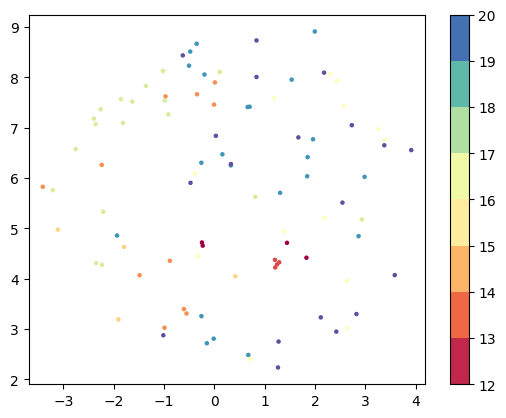

In [13]:
colors = df.loc[mask, 'Class']
print(set(colors))
size = len(set(colors))

plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(min(colors), max(colors) + 1))
plt.show()

In [47]:
import matplotlib

In [48]:
from itertools import combinations

In [49]:
cmap = matplotlib.colormaps['Paired']

In [50]:
mycmap = cmap(np.linspace(0, 1, 10))

In [51]:
def calculate_dispersion(group):
    # return np.sqrt(np.var(group[0]) + np.var(group[1])) # If created manually
    return np.sqrt(np.var(group['0']) + np.var(group['1']))  # If read from csv file

In [52]:
dispersion_per_class = emb_df_all.groupby('Class').apply(calculate_dispersion)

dispersion_df_all = pd.DataFrame({
    'class': dispersion_per_class.index,
    'dispersion': dispersion_per_class.values
})

In [53]:
dispersion_df_all.describe()

,class,dispersion
count,373.000000,373.000000
mean,208.890080,1.835863
std,120.784226,0.491459
min,1.000000,0.017660
25%,103.000000,1.530270
50%,209.000000,1.893293
75%,314.000000,2.181994
max,415.000000,3.144569


In [54]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_mean_distance(group):

    # points = list(zip(group[0],group[1])) # If created manually
    points = list(zip(group['0'],group['1'])) # If read from file
    distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
    avg_distance = sum(distances) / len(distances)
    return  avg_distance

In [55]:
mean_distance = emb_df_all.groupby('Class').apply(calculate_mean_distance)

mean_distance_df_all = pd.DataFrame({
    'class': mean_distance.index,
    'mean_distance': mean_distance.values
})

In [56]:
mean_distance_df_all.describe()

,class,mean_distance
count,373.000000,373.000000
mean,208.890080,2.401217
std,120.784226,0.656308
min,1.000000,0.021339
25%,103.000000,1.964280
50%,209.000000,2.422976
75%,314.000000,2.844236
max,415.000000,4.145095


In [57]:
mask_good_classes_dist = mean_distance_df_all[(mean_distance_df_all["mean_distance"] < mean_distance_df_all.describe().loc['25%']['mean_distance'])]["class"].unique().tolist()

In [58]:
mask_good_classes_dispersion = dispersion_df_all[(dispersion_df_all["dispersion"] < dispersion_df_all.describe().loc["25%"]['dispersion'])]["class"].unique().tolist()

In [59]:
mask_good = set(mask_good_classes_dist).intersection(set(mask_good_classes_dispersion))
print(len(mask_good))

88


In [60]:
df_good = df.loc[df["Class"].isin(mask_good)]

In [61]:
embedding_good = reducer.transform(df_good.iloc[:, :-1])

In [62]:
emb_df_good = pd.DataFrame(embedding_good)
emb_df_good["Class"] = df_good['Class'].tolist()

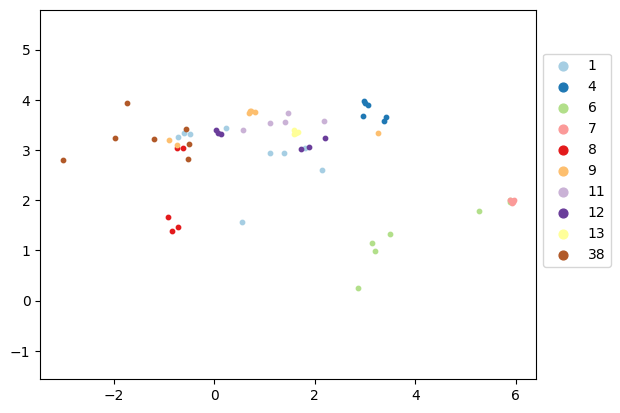

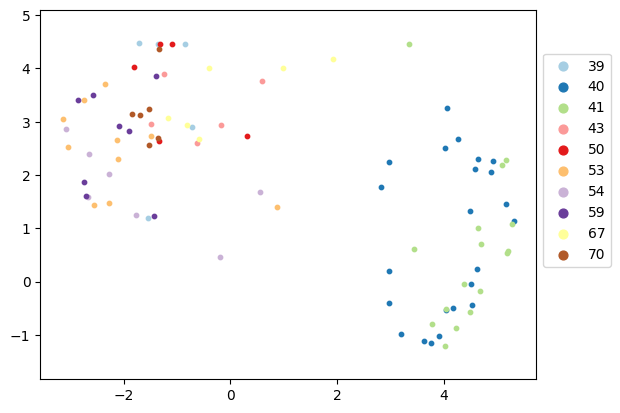

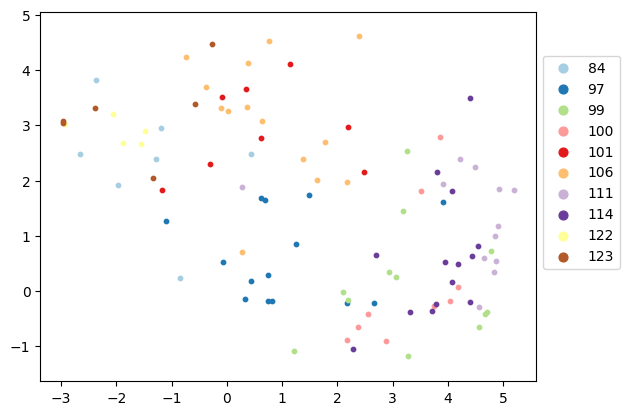

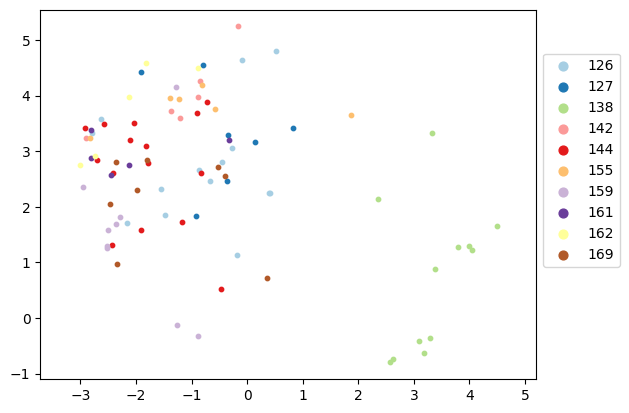

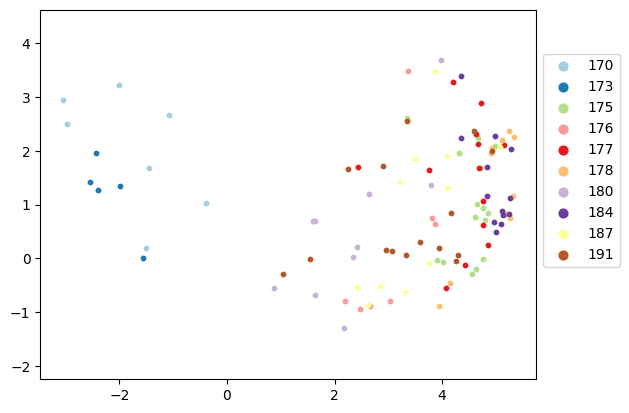

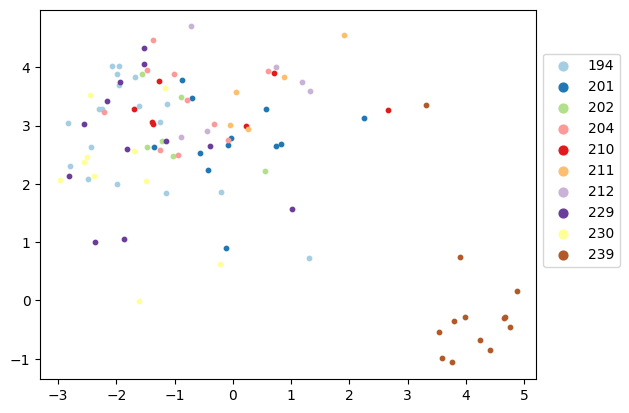

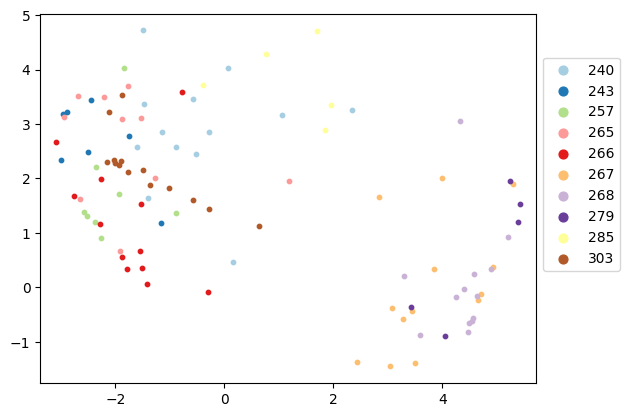

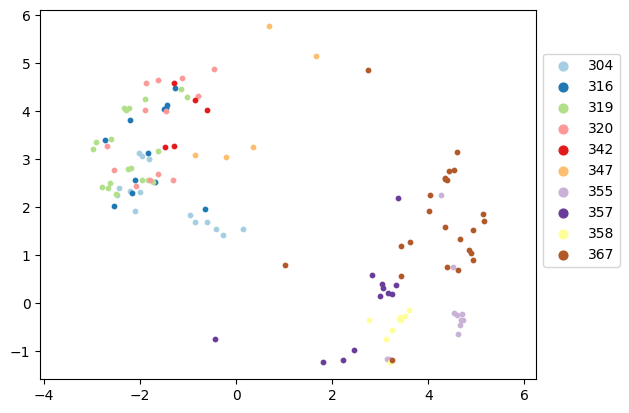

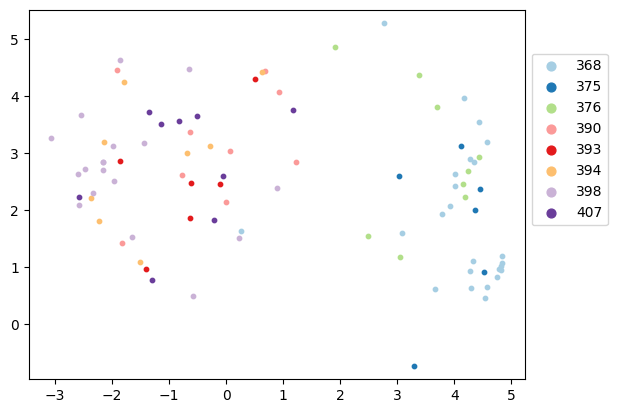

In [63]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num], s=10)
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,0.9))
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

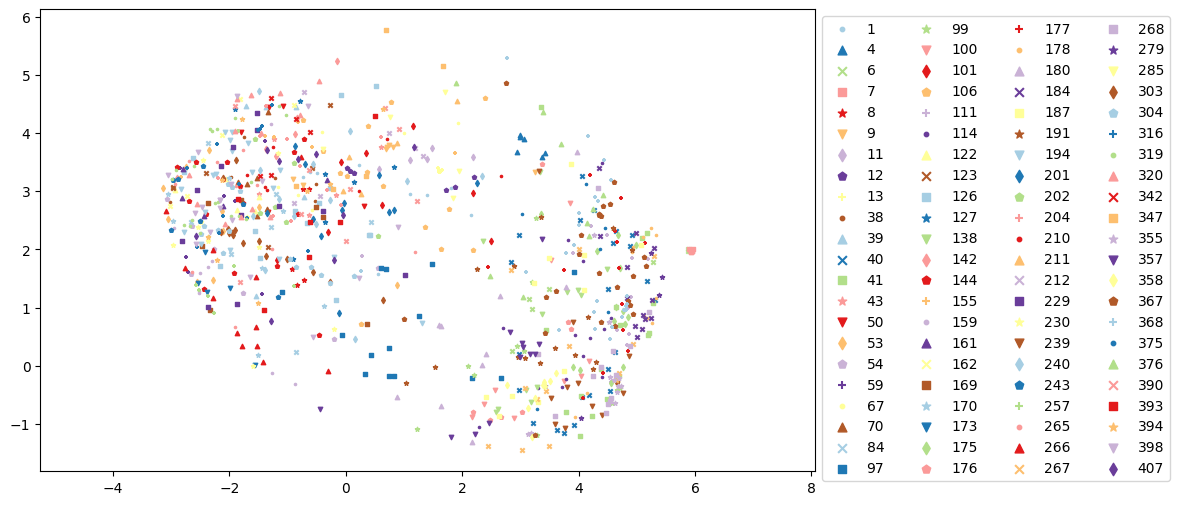

In [64]:
colors = df_good["Class"]
classes_unique = list(set(colors))
size = len(set(colors))

# chunks = [classes_unique[x:x + 10] for x in range(0, len(classes_unique), 10)]
chunks = [classes_unique]
marker_styles = [".", "^", "x", "s", "*", "v", "d", "p", "+"]
plt.figure(figsize=(10,6))
for chunk in chunks:
    cur_colors = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]["Class"]
    cur_emb_df = emb_df_good.loc[emb_df_good["Class"].isin(chunk)]
    scatter_list = []
    label_list = []
    for num, color in enumerate(chunk, start=0):
        scatter = plt.scatter(cur_emb_df.loc[cur_emb_df["Class"].isin([color])][0], cur_emb_df.loc[cur_emb_df["Class"].isin([color])][1], color=mycmap[num%10], s=10,
                              marker=marker_styles[num%len(marker_styles)])
        scatter_list.append(scatter)
        label_list.append(str(color))
    plt.gca().set_aspect('equal', 'datalim')
    lgnd = plt.legend(scatter_list, label_list, bbox_to_anchor=(1,1), ncol=4)
    for lgnhandle in lgnd.legend_handles:
        lgnhandle._sizes = [40]

    plt.show()

In [75]:
base_dir = os.path.abspath(os.path.join('', '..'))
data_dir = os.path.join(base_dir, "data", "datasets_preprocessed")
eye_id = 1

destination_dir_train = os.path.join(data_dir, "umap_filtered_train")
destination_dir_val = os.path.join(data_dir, "umap_filtered_val")
os.makedirs(destination_dir_train, exist_ok=True)
os.makedirs(destination_dir_val, exist_ok=True)
data_path = os.path.join(data_dir, "all_filtered_train")
data_path_train = os.path.join(data_dir, "all_filtered_train")
data_path_val = os.path.join(data_dir, "all_filtered_val")
for eye_dir in os.listdir(os.path.join(data_path)):
    if int(eye_dir.split("/")[-1]) in mask_good:

        cur_eye_dest_dir_train = os.path.join(destination_dir_train, str(eye_id))
        os.makedirs(cur_eye_dest_dir_train, exist_ok=True)
        for file in os.listdir(os.path.join(data_path_train, eye_dir)):
            shutil.copy(os.path.join(data_path_train, eye_dir, file), cur_eye_dest_dir_train)

        cur_eye_dest_dir_val = os.path.join(destination_dir_val, str(eye_id))
        os.makedirs(cur_eye_dest_dir_val, exist_ok=True)
        for file in os.listdir(os.path.join(data_path_val, eye_dir)):
            shutil.copy(os.path.join(data_path_val, eye_dir, file), cur_eye_dest_dir_val)
        eye_id += 1
